In [4]:
!pip install kaggle


In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d dhruvildave/spotify-charts


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/dhruvildave/spotify-charts
License(s): ODbL-1.0
100% 942M/945M [00:21<00:00, 76.7MB/s]
100% 945M/945M [00:21<00:00, 46.4MB/s]


In [6]:
from zipfile import ZipFile
dataset = '/content/spotify-charts.zip'
with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('Done')


Done


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('charts.csv')
df.head(10)

,title,rank,date,artist,url,region,chart,trend,streams
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,Argentina,top200,SAME_POSITION,253019.0
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul...,Argentina,top200,MOVE_UP,223988.0
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,https://open.spotify.com/track/3AEZUABDXNtecAO...,Argentina,top200,MOVE_DOWN,210943.0
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",https://open.spotify.com/track/6rQSrBHf7HlZjtc...,Argentina,top200,SAME_POSITION,173865.0
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,https://open.spotify.com/track/58IL315gMSTD37D...,Argentina,top200,MOVE_UP,153956.0
5,Traicionera,6,2017-01-01,Sebastian Yatra,https://open.spotify.com/track/5J1c3M4EldCfNxX...,Argentina,top200,MOVE_DOWN,151140.0
6,Cuando Se Pone a Bailar,7,2017-01-01,Rombai,https://open.spotify.com/track/1MpKZi1zTXpERKw...,Argentina,top200,MOVE_DOWN,148369.0
7,Otra vez (feat. J Balvin),8,2017-01-01,Zion & Lennox,https://open.spotify.com/track/3QwBODjSEzelZyV...,Argentina,top200,MOVE_DOWN,143004.0
8,La Bicicleta,9,2017-01-01,"Carlos Vives, Shakira",https://open.spotify.com/track/0sXvAOmXgjR2QUq...,Argentina,top200,MOVE_UP,126389.0
9,Dile Que Tu Me Quieres,10,2017-01-01,Ozuna,https://open.spotify.com/track/20ZAJdsKB5IGbGj...,Argentina,top200,MOVE_DOWN,112012.0


In [4]:
df['region'].value_counts()
df_US = df.loc[df['region']=='United States']
print(f"The data will be used {df_US.shape}")


The data will be used (455057, 9)


In [5]:
df_US['date']= pd.to_datetime(df_US['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26173514 entries, 0 to 26173513
Data columns (total 9 columns):
 #   Column   Dtype  
---  ------   -----  
 0   title    object 
 1   rank     int64  
 2   date     object 
 3   artist   object 
 4   url      object 
 5   region   object 
 6   chart    object 
 7   trend    object 
 8   streams  float64
dtypes: float64(1), int64(1), object(7)
memory usage: 1.8+ GB


In [6]:
df_US.isna().sum()
df_US.dropna(subset = ['streams'],inplace=True)
df_US.isna().sum()


,0
title,0
rank,0
date,0
artist,0
url,0
region,0
chart,0
trend,0
streams,0


In [7]:
describe_round = df_US.describe()
describe_round.round(2)


,rank,date,streams
count,364184.00,364184,364184.00
mean,100.50,2019-07-02 19:33:56.412363008,390275.48
min,1.00,2017-01-01 00:00:00,122488.00
25%,51.00,2018-04-04 00:00:00,236157.00
50%,100.50,2019-07-03 00:00:00,294791.50
75%,150.00,2020-09-30 00:00:00,434688.25
max,200.00,2021-12-31 00:00:00,6146233.00
std,57.73,NaN,278800.88


In [8]:
df_US.info()


<class 'pandas.core.frame.DataFrame'>
Index: 364184 entries, 8246 to 25275873
Data columns (total 9 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   title    364184 non-null  object        
 1   rank     364184 non-null  int64         
 2   date     364184 non-null  datetime64[ns]
 3   artist   364184 non-null  object        
 4   url      364184 non-null  object        
 5   region   364184 non-null  object        
 6   chart    364184 non-null  object        
 7   trend    364184 non-null  object        
 8   streams  364184 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 27.8+ MB


In [9]:
df_US.drop(['url','chart'],axis=1,inplace=True)
df_US.columns

Index(['title', 'rank', 'date', 'artist', 'region', 'trend', 'streams'], dtype='object')

In [10]:
artist_popularity = df_US.groupby('artist')['streams'].sum().reset_index()
artist_popularity.columns = ['artist', 'artist_total_streams']
df_US = df_US.merge(artist_popularity)
df_US

,title,rank,date,artist,region,trend,streams,artist_total_streams
0,Bad and Boujee (feat. Lil Uzi Vert),1,2017-01-01,Migos,United States,SAME_POSITION,1371493.0,1.080773e+09
1,Stir Fry,5,2018-03-01,Migos,United States,SAME_POSITION,1253369.0,1.080773e+09
2,Narcos,15,2018-03-01,Migos,United States,SAME_POSITION,786076.0,1.080773e+09
3,Slippery (feat. Gucci Mane),100,2018-03-01,Migos,United States,MOVE_UP,300580.0,1.080773e+09
4,Gang Gang,173,2018-03-01,Migos,United States,MOVE_DOWN,210003.0,1.080773e+09
...,...,...,...,...,...,...,...,...
364179,The Monster,158,2021-10-31,"Eminem, Rihanna",United States,NEW_ENTRY,221482.0,2.214820e+05
364180,"My Family - from ""The Addams Family""",170,2021-10-31,"Migos, KAROL G, Snoop Dogg, Rock Mafia",United States,NEW_ENTRY,215102.0,2.151020e+05
364181,Tainted Love,174,2021-10-31,Soft Cell,United States,NEW_ENTRY,212994.0,2.129940e+05
364182,Sad Girlz Luv Money Remix (feat. Kali Uchis),198,2021-10-31,"Amaarae, Moliy",United States,NEW_ENTRY,204378.0,2.043780e+05


In [11]:
df_US['year'] = df_US['date'].dt.year
df_US['month'] = df_US['date'].dt.month
df

,title,rank,date,artist,url,region,chart,trend,streams
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,Argentina,top200,SAME_POSITION,253019.0
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul...,Argentina,top200,MOVE_UP,223988.0
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,https://open.spotify.com/track/3AEZUABDXNtecAO...,Argentina,top200,MOVE_DOWN,210943.0
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",https://open.spotify.com/track/6rQSrBHf7HlZjtc...,Argentina,top200,SAME_POSITION,173865.0
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,https://open.spotify.com/track/58IL315gMSTD37D...,Argentina,top200,MOVE_UP,153956.0
...,...,...,...,...,...,...,...,...,...
26173509,BYE,46,2021-07-31,Jaden,https://open.spotify.com/track/3OUyyDN7EZrL7i0...,Vietnam,viral50,MOVE_UP,NaN
26173510,Pillars,47,2021-07-31,My Anh,https://open.spotify.com/track/6eky30oFiQbHUAT...,Vietnam,viral50,NEW_ENTRY,NaN
26173511,Gái Độc Thân,48,2021-07-31,Tlinh,https://open.spotify.com/track/2klsSb2iTfgDh95...,Vietnam,viral50,MOVE_DOWN,NaN
26173512,Renegade (feat. Taylor Swift),49,2021-07-31,Big Red Machine,https://open.spotify.com/track/1aU1wpYBSpP0M6I...,Vietnam,viral50,MOVE_DOWN,NaN


In [12]:
average_streams_per_song = df.groupby(['title', 'artist'])['streams'].mean().reset_index()
df_US = df_US.merge(average_streams_per_song, on=['title', 'artist'], how='left')
df_US.rename(columns={'streams_x':'streams','streams_y':'average_streams'},inplace=True)
df_US

,title,rank,date,artist,region,trend,streams,artist_total_streams,year,month,average_streams
0,Bad and Boujee (feat. Lil Uzi Vert),1,2017-01-01,Migos,United States,SAME_POSITION,1371493.0,1.080773e+09,2017,1,110278.075672
1,Stir Fry,5,2018-03-01,Migos,United States,SAME_POSITION,1253369.0,1.080773e+09,2018,3,133362.331841
2,Narcos,15,2018-03-01,Migos,United States,SAME_POSITION,786076.0,1.080773e+09,2018,3,124268.331616
3,Slippery (feat. Gucci Mane),100,2018-03-01,Migos,United States,MOVE_UP,300580.0,1.080773e+09,2018,3,199729.716312
4,Gang Gang,173,2018-03-01,Migos,United States,MOVE_DOWN,210003.0,1.080773e+09,2018,3,143109.325843
...,...,...,...,...,...,...,...,...,...,...,...
364179,The Monster,158,2021-10-31,"Eminem, Rihanna",United States,NEW_ENTRY,221482.0,2.214820e+05,2021,10,48103.538462
364180,"My Family - from ""The Addams Family""",170,2021-10-31,"Migos, KAROL G, Snoop Dogg, Rock Mafia",United States,NEW_ENTRY,215102.0,2.151020e+05,2021,10,126944.500000
364181,Tainted Love,174,2021-10-31,Soft Cell,United States,NEW_ENTRY,212994.0,2.129940e+05,2021,10,53874.076923
364182,Sad Girlz Luv Money Remix (feat. Kali Uchis),198,2021-10-31,"Amaarae, Moliy",United States,NEW_ENTRY,204378.0,2.043780e+05,2021,10,23047.083333


In [13]:
df_US.to_csv('df US_spotify.csv',index=False)


In [14]:
!pip install plotly==5.15.0


In [15]:
df.head()

,title,rank,date,artist,url,region,chart,trend,streams
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,Argentina,top200,SAME_POSITION,253019.0
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul...,Argentina,top200,MOVE_UP,223988.0
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,https://open.spotify.com/track/3AEZUABDXNtecAO...,Argentina,top200,MOVE_DOWN,210943.0
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",https://open.spotify.com/track/6rQSrBHf7HlZjtc...,Argentina,top200,SAME_POSITION,173865.0
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,https://open.spotify.com/track/58IL315gMSTD37D...,Argentina,top200,MOVE_UP,153956.0


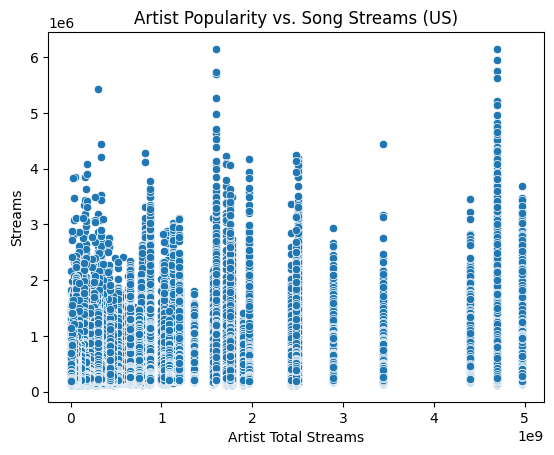

In [16]:
import seaborn as sns

# Scatter plot of artist popularity vs. streams
sns.scatterplot(x='artist_total_streams', y='streams', data=df_US)
plt.xlabel('Artist Total Streams')
plt.ylabel('Streams')
plt.title('Artist Popularity vs. Song Streams (US)')
plt.show()

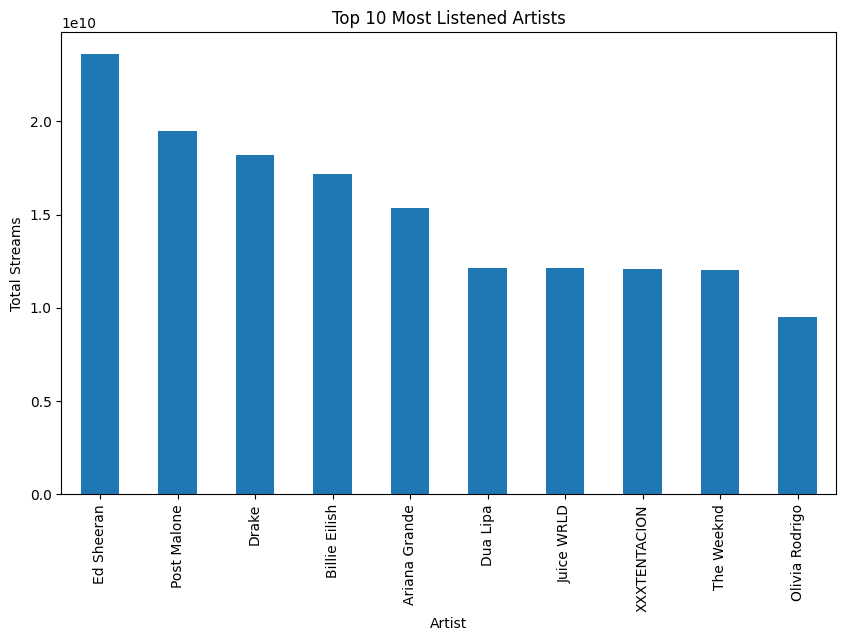

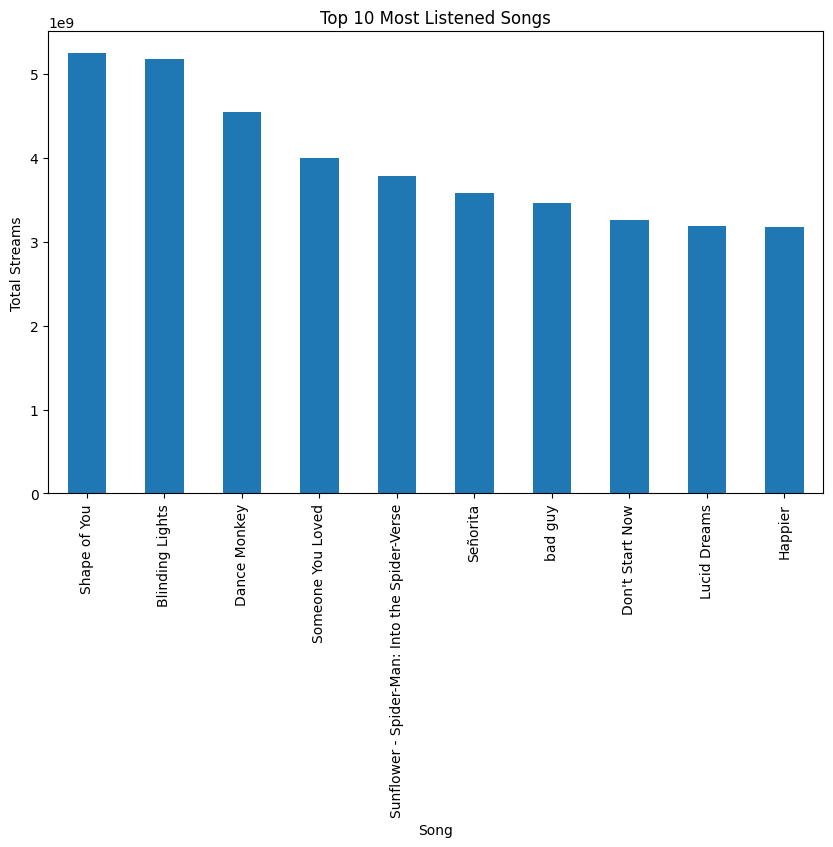

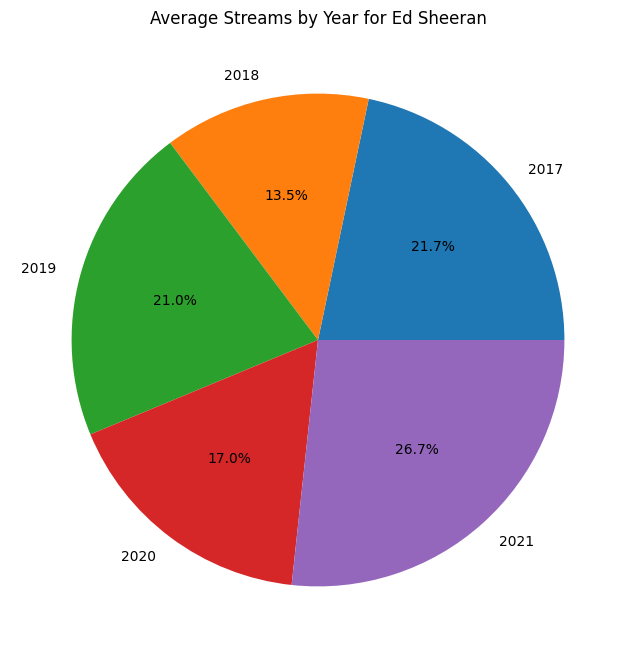

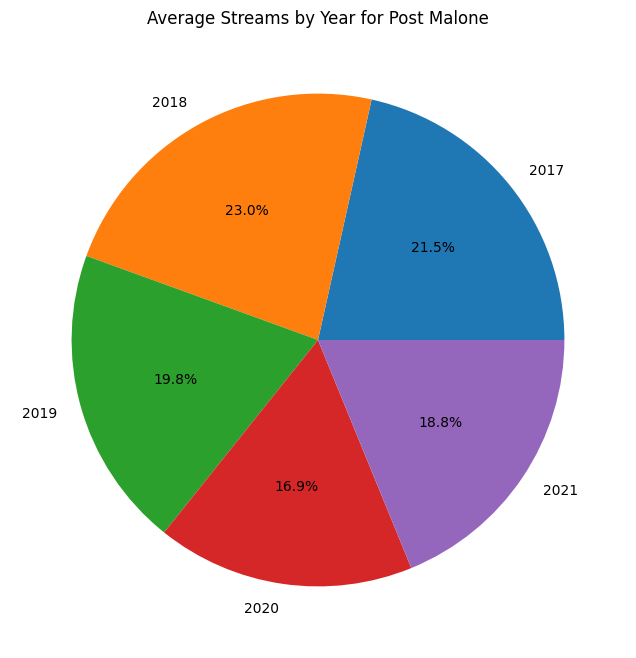

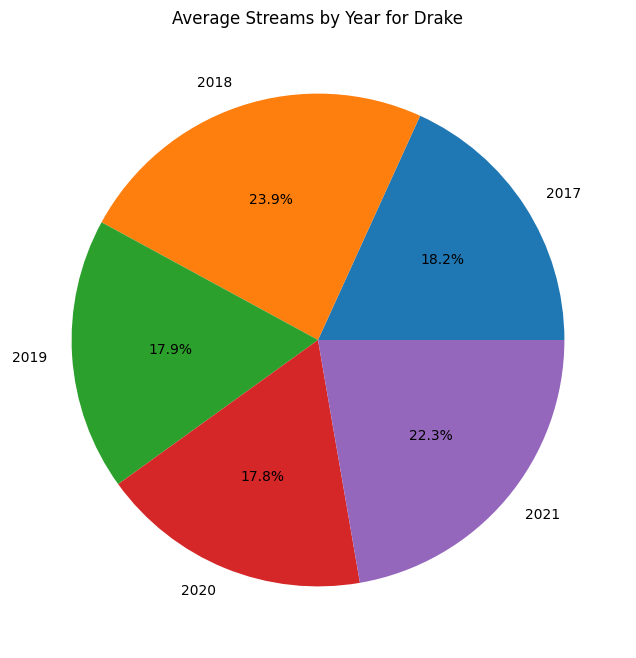

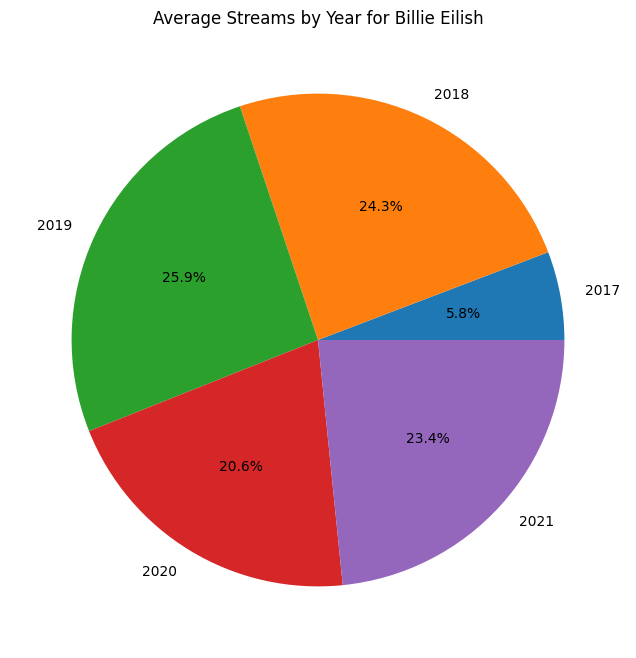

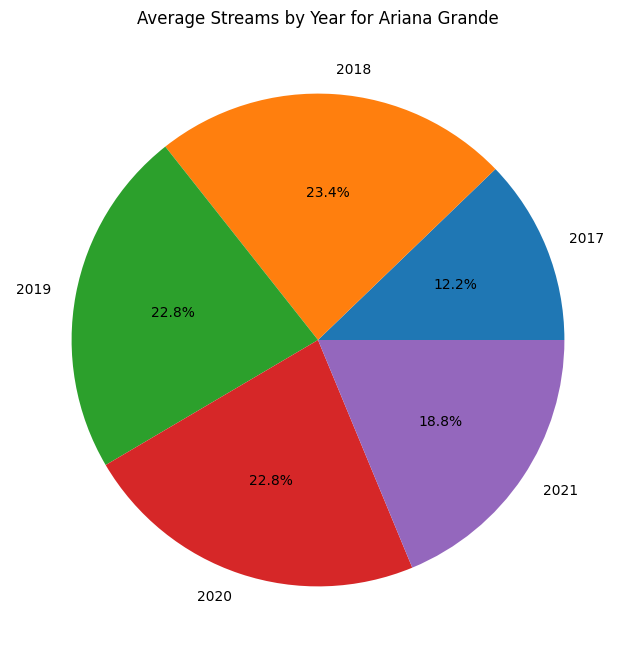

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the DataFrame named 'df'

# Top 10 most listened to artists
top_artists = df.groupby('artist')['streams'].sum().sort_values(ascending=False).head(10)

# Visualize top artists
plt.figure(figsize=(10, 6))
top_artists.plot(kind='bar')
plt.title('Top 10 Most Listened Artists')
plt.xlabel('Artist')
plt.ylabel('Total Streams')
plt.show()

# Top 10 most listened to songs
top_songs = df.groupby('title')['streams'].sum().sort_values(ascending=False).head(10)

# Visualize top songs
plt.figure(figsize=(10, 6))
top_songs.plot(kind='bar')
plt.title('Top 10 Most Listened Songs')
plt.xlabel('Song')
plt.ylabel('Total Streams')
plt.show()

# Filter for the top 5 artists based on total streams
top_artists = df.groupby('artist')['streams'].sum().sort_values(ascending=False).head(5)

# Create a new DataFrame with only the top 5 artists
df_top_artists = df[df['artist'].isin(top_artists.index)]

# Try converting 'date' to datetime format (handle potential errors)
try:
  df_top_artists['year'] = pd.to_datetime(df_top_artists['date']).dt.year
except:
  print("Error converting 'date' to datetime. Check the format of the column.")

# If conversion worked, proceed with calculating average streams by year
if 'year' in df_top_artists.columns:
  average_streams_by_year = df_top_artists.groupby(['artist', 'year'])['streams'].mean().reset_index()

  # Create a pie chart for each artist
  for artist in top_artists.index:
      artist_data = average_streams_by_year[average_streams_by_year['artist'] == artist]
      plt.figure(figsize=(8, 8))
      plt.pie(artist_data['streams'], labels=artist_data['year'], autopct='%1.1f%%')
      plt.title(f'Average Streams by Year for {artist}')
      plt.show()
else:
  print("'year' column not available. Unable to calculate average streams by year.")